# Computing the smallest surface of revolution

## Import statements

In [1]:
# Modify path environment variables to search for the local Pyritz and NLopt installations in the repository.

import os, sys

pyritz_dir = "/".join(os.getcwd().split("/")[:-1])
nlopt_lib_dir = "%s/nlopt/lib" % pyritz_dir
nlopt_py_dir = "%s/nlopt/nlopt_py" % pyritz_dir

if 'LD_LIBRARY_PATH' in os.environ:
    paths = os.environ['LD_LIBRARY_PATH'].split(":")
    paths.append(nlopt_lib_dir)
    os.environ['LD_LIBRARY_PATH'] = ":".join(paths)
else:
    os.environ['LD_LIBRARY_PATH'] = ":%s" % nlopt_lib_dir
    
sys.path.insert(0, nlopt_py_dir)
sys.path.insert(0, pyritz_dir)

# Import statements

import pyritz

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt

## Define system

#### Lagrangian:

Consider the surface of revolution of a curve $y(x)$ with $y(x_1)=y_1$ and $y(x_2)=y_2$ around the $x$-axis,

$$
A[y(x)] = 2 \pi \int_{x_1}^{x_2} |y| \sqrt{1 + (y')^2}.
$$

We want to find the curve $y(x)$ that minimises the surface. The analytic solution is

$$
y(x) = A \cosh \left(B + \frac{x}{A} \right)
$$

where $A$ and $B$ must be chosen to satisfy the boundary conditions.

Below, the solution to the problem is found using PyRitz, with boundary conditions $y(-1) = \cosh 0$ and $y(1) = \cosh 2$ (By default, `pyritz.interpolate` uses $x_1 = -1$ and $x_2 = 1$ as the limits of integration). 

In [2]:
# System Lagrangian

def lagrangian(ls, dxls, dvls, path, xs, args):
    ys, dys = path
    ls[:] = 2*np.pi*np.abs(ys)*np.sqrt(1 + dys*dys)

## Gradient-free optimisation

In [10]:
y1 = np.cosh(0)
y2 = np.cosh(2)

n = 8
nq = n*10

alpha0 = pyritz.interpolation.utils.linear_path(y1, y2, n)

action = pyritz.interpolation.Action(lagrangian, n, nq, y1, y2)

opt = nlopt.opt(nlopt.LN_NEWUOA, np.size(alpha0))
opt.set_lower_bounds(np.full(np.size(alpha0), 0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-10)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

S[alpha0] = 51.01386317532773
S[alpha]  = 49.135826695371414


#### Solution plot

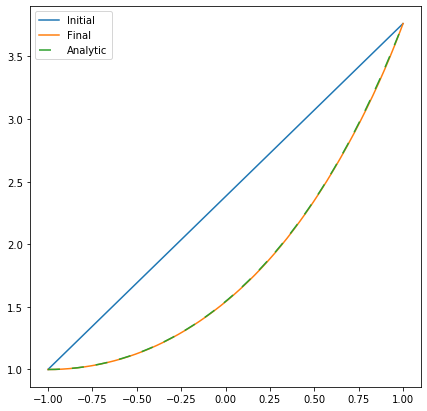

In [11]:
def analytic_sol(xs):
    return np.cosh(1 + xs)

xs = np.linspace(-1, 1, 1000)

paths = [
    (action.get_alpha_with_endpoints(alpha0), "Initial"),
    (action.get_alpha_with_endpoints(alpha), "Final")
]

for _alpha, _label in paths:
    ys = pyritz.interpolation.utils.interpolate(_alpha, n, xs)
    plt.plot(xs, ys[0,:], label=_label)

plt.plot(xs, analytic_sol(xs), "--", dashes=(8, 8), label="Analytic")
plt.legend()
mpl.pyplot.gcf().set_size_inches(7, 7)